In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Bước 1: Chuẩn bị dữ liệu
df = pd.read_csv('data/Heartdata.csv')
df = df.sort_values(by='num')
num_counts = df['num'].value_counts().sort_index()
print(num_counts)

features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
target = 'num'
X = df[features].values
y = df[target].values

num_classes = len(np.unique(y))   
y_one_hot = np.eye(num_classes)[y]  

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.3, random_state=41, stratify=y)

# Bước 2: Các hàm kích hoạt và dropout
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True)) # tính toán hàm mũ trong z (trừ đi dể tránh tràn mũ)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)  #tạo thành sắc xuất

def leaky_relu(z, alpha=0.01): #tránh hiện tượng chết nơ-ron trong mạng nơ-ron
    return np.maximum(alpha * z, z) 

def leaky_relu_backward(dA, Z, alpha=0.01):
    dZ = np.array(dA, copy=True) # Tạo một bản sao của dA (đạo hàm của hàm mất mát đối với đầu ra) để tính đạo hàm của Leaky ReLU.
    dZ[Z <= 0] *= alpha
    return dZ

def dropout(A, dropout_rate): #giảm overfitting
    mask = np.random.rand(*A.shape) > dropout_rate
    A = A * mask
    A = A / (1 - dropout_rate)
    return A, mask 

# Bước 3: Tính hàm chi phí
def compute_cost(A, y, parameters, lambda_):
    m = y.shape[0]
    cost = (-1/m) * np.sum(y * np.log(A + 1e-8))
    # lamda hệ số hiệu chỉnh chuẩn hóa
    L2_regularization_cost = (lambda_/2) * sum(np.sum(np.square(parameters[key])) for key in parameters if 'W' in key)
    return cost + L2_regularization_cost

# Bước 4: Lan truyền và tối ưu hóa
def propagate(X, y, parameters, lambda_, dropout_rate=0.2):
    m = X.shape[0]

    Z1 = np.dot(X, parameters['W1']) + parameters['b1']
    A1 = leaky_relu(Z1)
    A1, mask1 = dropout(A1, dropout_rate)

    Z2 = np.dot(A1, parameters['W2']) + parameters['b2']
    A2 = leaky_relu(Z2)
    A2, mask2 = dropout(A2, dropout_rate)

    Z3 = np.dot(A2, parameters['W3']) + parameters['b3']
    A3 = softmax(Z3)
    cost = compute_cost(A3, y, parameters, lambda_)

    # Lan truyền ngược
    dZ3 = A3 - y
    dW3 = (1/m) * np.dot(A2.T, dZ3) + (lambda_/m) * parameters['W3']
    db3 = (1/m) * np.sum(dZ3, axis=0, keepdims=True)

    dA2 = np.dot(dZ3, parameters['W3'].T)
    dZ2 = leaky_relu_backward(dA2, Z2)
    dW2 = (1/m) * np.dot(A1.T, dZ2) + (lambda_/m) * parameters['W2']
    db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)

    dA1 = np.dot(dZ2, parameters['W2'].T)
    dZ1 = leaky_relu_backward(dA1, Z1)
    dW1 = (1/m) * np.dot(X.T, dZ1) + (lambda_/m) * parameters['W1']
    db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)

    grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2, 'dW3': dW3, 'db3': db3}
    return grads, cost

def optimize(X, y, num_iterations, learning_rate, n_hidden, n_hidden2, lambda_, dropout_rate):
    num_features = X.shape[1]
    num_classes = y.shape[1]

    parameters = {
        'W1': np.random.randn(num_features, n_hidden) * 0.01,
        'b1': np.zeros((1, n_hidden)),
        'W2': np.random.randn(n_hidden, n_hidden2) * 0.01,
        'b2': np.zeros((1, n_hidden2)),
        'W3': np.random.randn(n_hidden2, num_classes) * 0.01,
        'b3': np.zeros((1, num_classes))
    }

    costs = []
    for i in range(num_iterations):
        grads, cost = propagate(X, y, parameters, lambda_, dropout_rate)

        for key in parameters:
            if 'W' in key or 'b' in key:
                parameters[key] -= learning_rate * grads['d' + key]

        if i % 100 == 0:
            costs.append(cost)

    return parameters, costs

def predict(X, parameters):
    Z1 = np.dot(X, parameters['W1']) + parameters['b1']
    A1 = leaky_relu(Z1)

    Z2 = np.dot(A1, parameters['W2']) + parameters['b2']
    A2 = leaky_relu(Z2)

    Z3 = np.dot(A2, parameters['W3']) + parameters['b3']
    A3 = softmax(Z3)
    return np.argmax(A3, axis=1)

# Bước 5: Huấn luyện và đánh giá
n_hidden = 150
n_hidden2 = 70
lambda_ = 0.1
learning_rate = 0.1
num_iterations = 600
dropout_rate = 0.02

parameters, costs = optimize(X_train, y_train, num_iterations, learning_rate, n_hidden, n_hidden2, lambda_, dropout_rate)

# Dự đoán
y_pred = predict(X_test, parameters)
y_test_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_labels, y_pred) * 100
print(f"Accuracy on test data: {accuracy:.2f}%")

conf_matrix = confusion_matrix(y_test_labels, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

class_report = classification_report(y_test_labels, y_pred)
print('Classification Report:')
print(class_report)



num
0    160
1     54
2     45
3     35
Name: count, dtype: int64
Accuracy on test data: 71.91%
Confusion Matrix:
[[47  0  1  0]
 [ 6  4  4  2]
 [ 2  2 10  0]
 [ 1  1  6  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90        48
           1       0.57      0.25      0.35        16
           2       0.48      0.71      0.57        14
           3       0.60      0.27      0.38        11

    accuracy                           0.72        89
   macro avg       0.62      0.55      0.55        89
weighted avg       0.70      0.72      0.69        89



In [31]:
# Lưu mô hình vào model_params
model_params = {
    "W1": parameters['W1'].tolist(),
    "b1": parameters['b1'].tolist(),
    "W2": parameters['W2'].tolist(),
    "b2": parameters['b2'].tolist(),
    "W3": parameters['W3'].tolist(),
    "b3": parameters['b3'].tolist()
}

# Lưu vào tệp JSON
with open("model_params.json", "w") as json_file:
    json.dump(model_params, json_file)
print("Model parameters have been saved to 'model_params.json'.")


Model parameters have been saved to 'model_params.json'.


LRegression  Accuracy: 62.92%
Confusion Matrix (LRegression ):
[[46  1  0  1]
 [ 6  2  3  5]
 [ 2  4  6  2]
 [ 0  2  7  2]]
Classification Report (LRegression ):
              precision    recall  f1-score   support

           0       0.85      0.96      0.90        48
           1       0.22      0.12      0.16        16
           2       0.38      0.43      0.40        14
           3       0.20      0.18      0.19        11

    accuracy                           0.63        89
   macro avg       0.41      0.42      0.41        89
weighted avg       0.58      0.63      0.60        89

Random Forest Accuracy: 64.04%
Confusion Matrix (Random Forest):
[[46  1  0  1]
 [ 6  2  4  4]
 [ 4  2  7  1]
 [ 2  2  5  2]]
Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.79      0.96      0.87        48
           1       0.29      0.12      0.17        16
           2       0.44      0.50      0.47        14
           3       0.

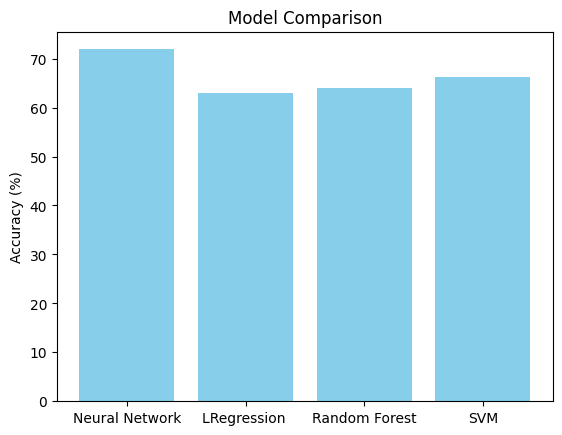

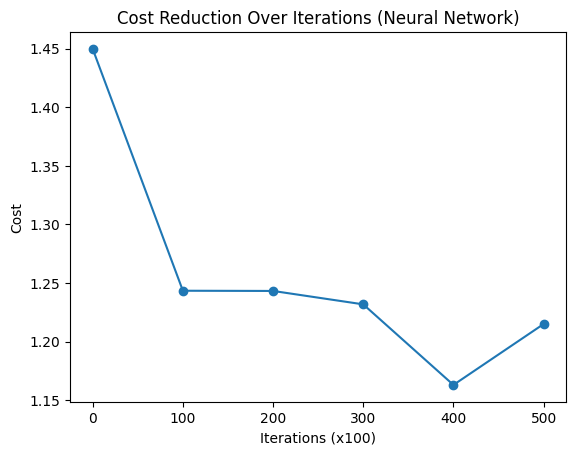

In [32]:
# So sánh với các mô hình khác
models = {
    "LRegression ": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=41),
    "SVM": SVC(kernel='linear', probability=True)
}

accuracies = []
for name, model in models.items():
    model.fit(X_train, np.argmax(y_train, axis=1))
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test_labels, y_pred) * 100
    accuracies.append((name, acc))
    print(f"{name} Accuracy: {acc:.2f}%")
    print(f"Confusion Matrix ({name}):")
    print(confusion_matrix(y_test_labels, y_pred))
    print(f"Classification Report ({name}):")
    print(classification_report(y_test_labels, y_pred))

# Vẽ đồ thị so sánh hiệu suất
model_names, model_accuracies = zip(*accuracies)
plt.bar(["Neural Network"] + list(model_names), [accuracy] + list(model_accuracies), color='skyblue')
plt.title("Model Comparison")
plt.ylabel("Accuracy (%)")
plt.show()

# Vẽ đồ thị chi phí huấn luyện
plt.plot(range(0, num_iterations, 100), costs, marker='o')
plt.title("Cost Reduction Over Iterations (Neural Network)")
plt.xlabel("Iterations (x100)")
plt.ylabel("Cost")
plt.show()

In [34]:
# Giả sử X_new là tập dữ liệu mới
X_new = np.array([[60, 5, 3, 150, 240, 0, 1, 121, 0, 0.9, 2, 0, 2]])  # Ví dụ một mẫu dữ liệu mới
X_new = scaler.transform(X_new)
y_pred_new = predict(X_new, parameters)
print(f"Dự đoán cho dữ liệu mới: {y_pred_new}")

Dự đoán cho dữ liệu mới: [0]
